In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.io import wavfile
import IPython.display as ipd
import librosa.display
import librosa
%matplotlib inline

In [2]:
df=pd.read_csv('train.csv')

In [2]:
list_instrument=['Hi-hat', 'Saxophone', 'Trumpet','Glockenspiel', 'Cello','Clarinet', 'Snare_drum','Oboe', 'Flute'
                 ,'Bass_drum','Harmonica','Gong','Double_bass','Tambourine','Electric_piano','Acoustic_guitar',
       'Violin_or_fiddle']

In [3]:
env_sounds=['Knock','Gunshot_or_gunfire','Computer_keyboard',
       'Keys_jangling', 'Writing', 'Laughter', 'Tearing',
       'Fart', 'Cough', 'Telephone', 'Bark', 'Bus', 'Squeak', 'Scissors',
       'Microwave_oven', 'Burping_or_eructation', 'Shatter',
       'Fireworks', 'Cowbell', 'Meow','Chime',
       'Drawer_open_or_close', 'Applause', 'Finger_snapping']

In [34]:
df_instruments=pd.DataFrame()
for i in list_instrument:
    df_instruments=pd.concat([df_instruments,df[df['label']==str(i)]],axis=0)

In [35]:
df_instruments.reset_index(inplace=True)

In [36]:
df_instruments.drop('index',inplace=True,axis=1)

In [37]:
df_instruments.drop('manually_verified',inplace=True,axis=1)

In [38]:
df_env=pd.DataFrame()
for i in env_sounds:
    df_env=pd.concat([df_env,df[df['label']==str(i)]],axis=0)

In [39]:
df_env.reset_index(inplace=True)

In [40]:
df_env.drop(['index','manually_verified'],inplace=True,axis=1)

In [41]:
df_instruments.set_index('fname',inplace=True)

In [42]:
df_env.set_index('fname',inplace=True)

In [47]:
for f in tqdm(df_env.index):
    wav,rate=librosa.load('audio_train/'+f,sr=44100)
    df_env.at[f,'length']=wav.shape[0]/44100

100%|██████████████████████████████████████████████████████████████████████████████| 4952/4952 [04:05<00:00, 20.16it/s]


In [48]:
for f in tqdm(df_instruments.index):
    wav,rate=librosa.load('audio_train/'+f,sr=44100)
    df_instruments.at[f,'length']=wav.shape[0]/44100

100%|██████████████████████████████████████████████████████████████████████████████| 4521/4521 [03:47<00:00, 25.37it/s]


In [49]:
def label_instrument(label):
    return list_instrument.index(label)

In [50]:
def label_env(label):
    return env_sounds.index(label)

In [51]:
df_instruments['target']=df_instruments['label'].apply(label_instrument)

In [52]:
df_env['target']=df_env['label'].apply(label_env)

In [53]:
df_env.to_csv('env_sounds.csv')
#df_env=pd.read_csv('env_sounds.csv')

In [54]:
df_instruments.to_csv('instruments.csv')
#df_instruments=pd.read_csv('instruments.csv')

# Checking the length of the audio files

C:\Users\Hp\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([ -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.]),
 <a list of 9 Text yticklabel objects>)

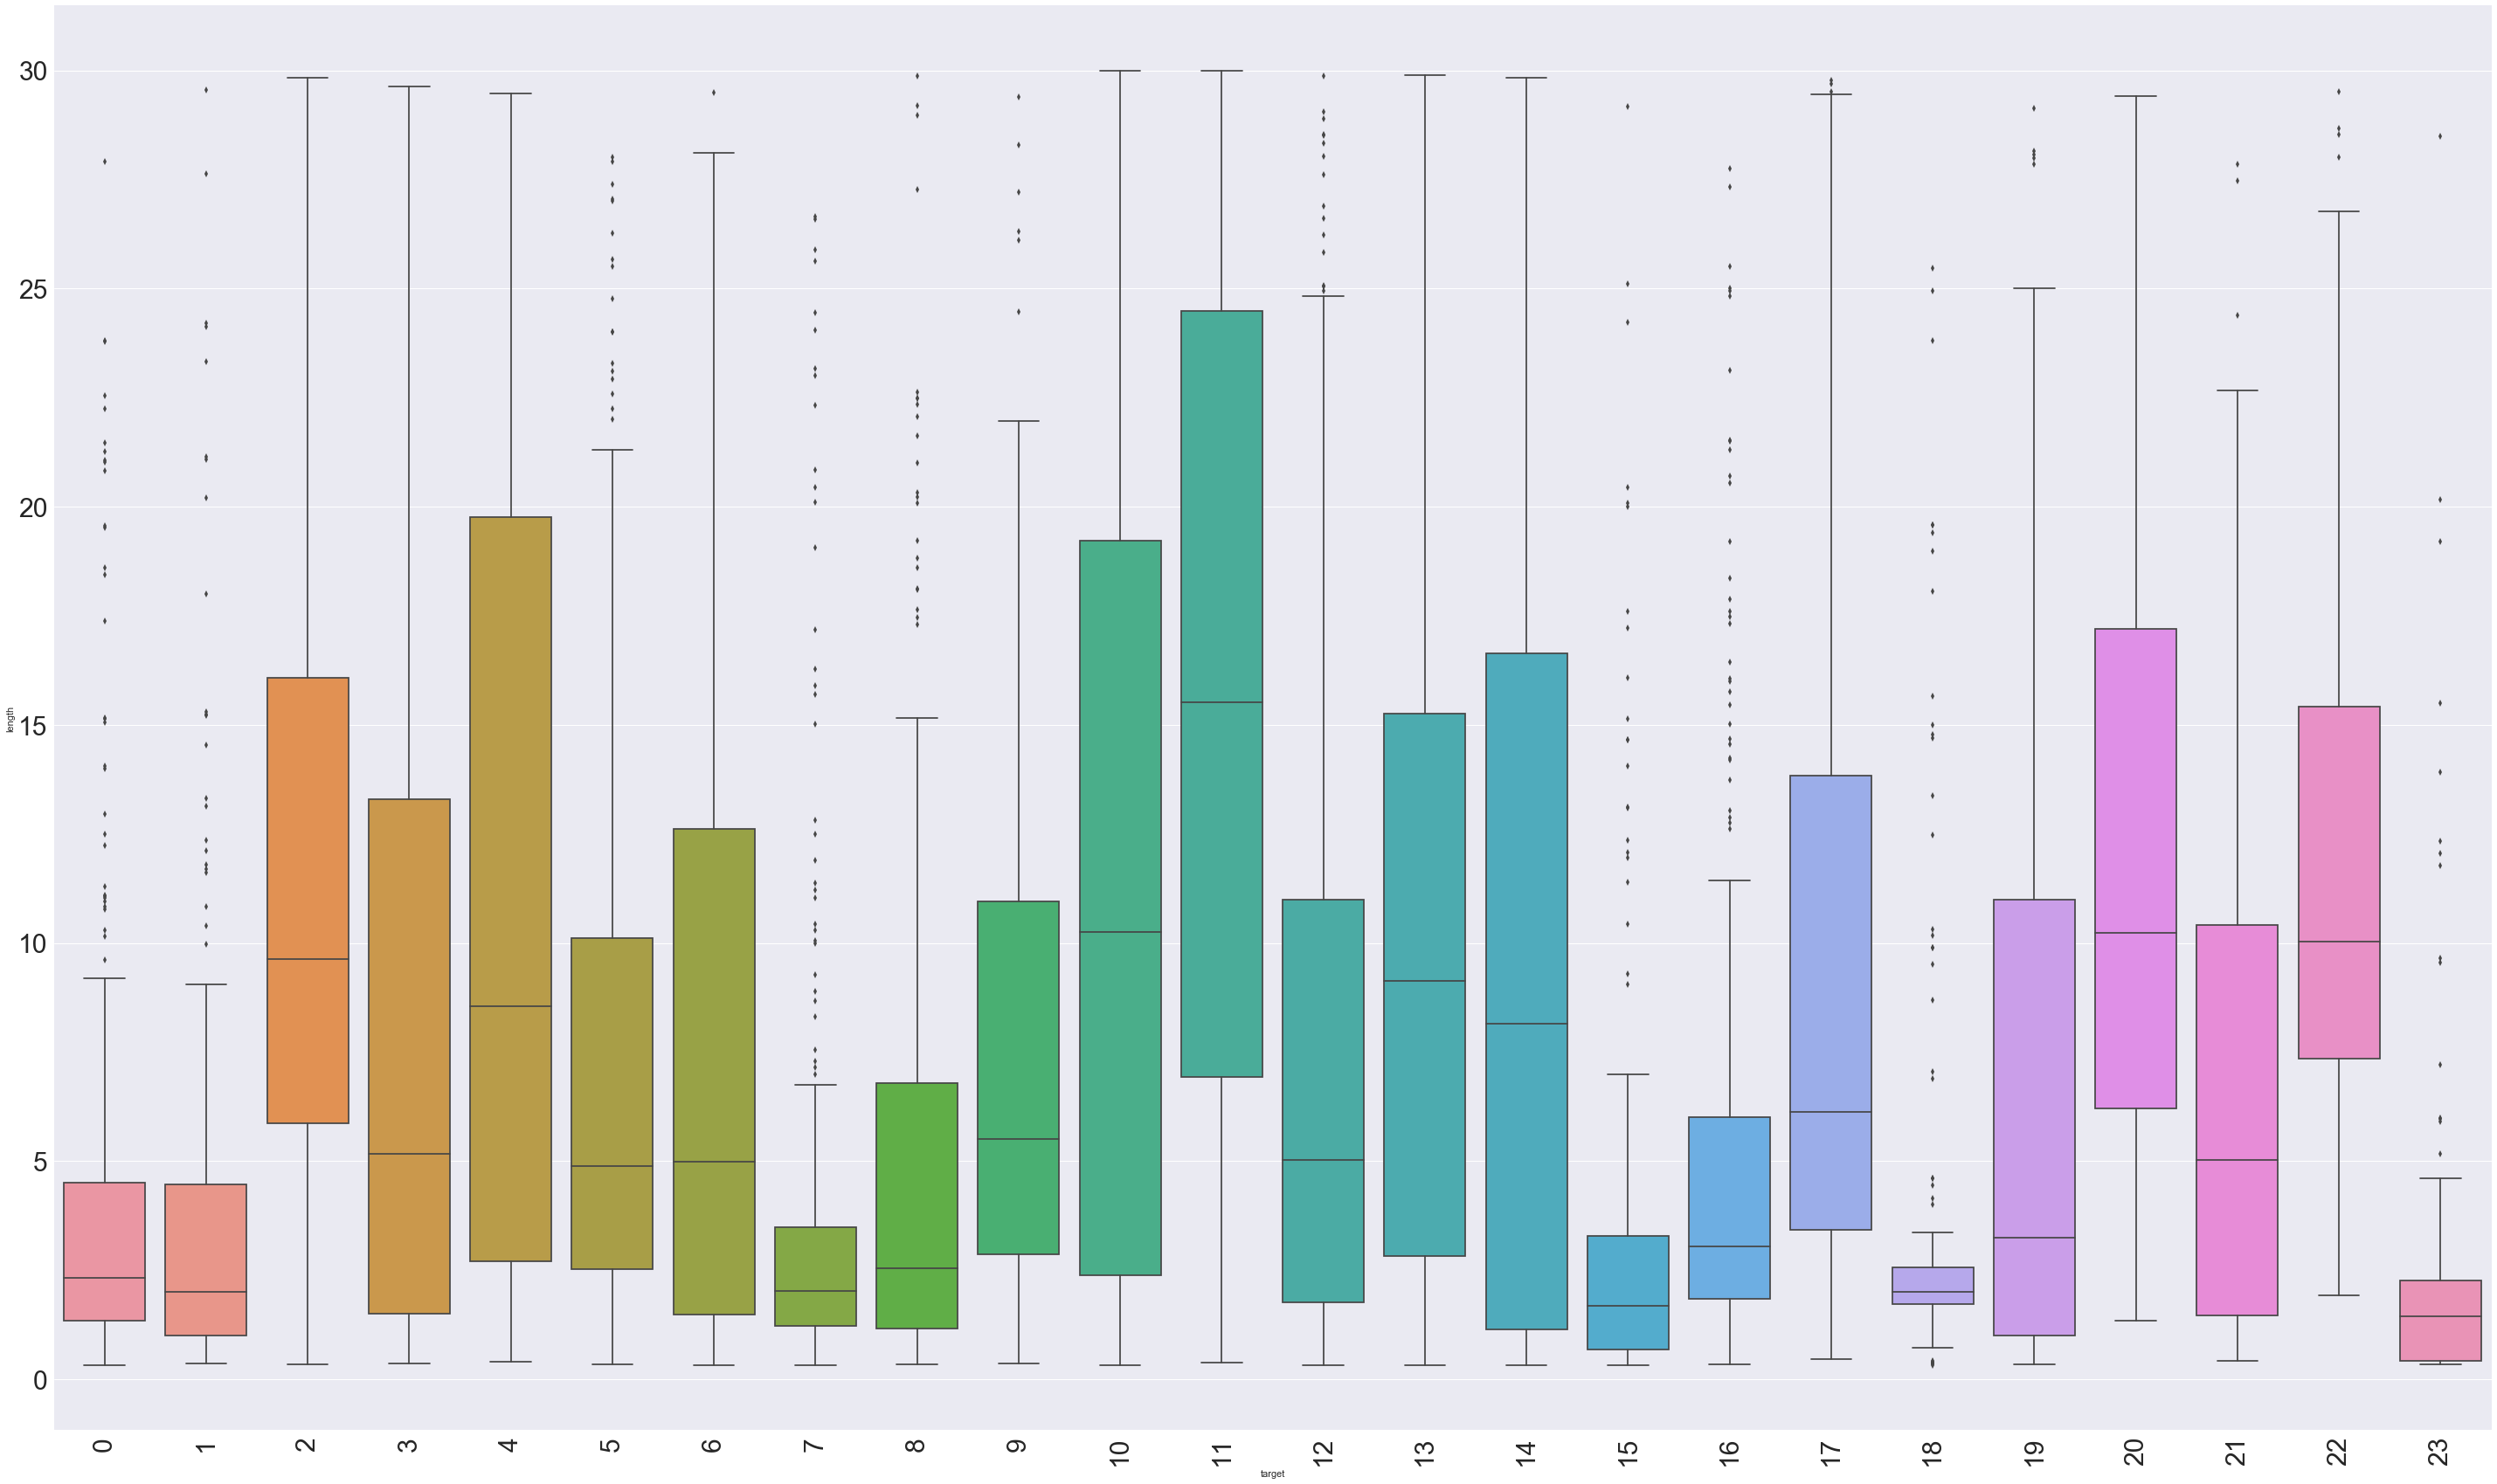

In [66]:
ax,fig=plt.subplots(figsize=(50,30))
sns.boxplot(x='target',y='length',data=df_env)
plt.xticks(fontsize=30, rotation='vertical')
plt.yticks(fontsize=30)


C:\Users\Hp\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([ -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.]),
 <a list of 9 Text yticklabel objects>)

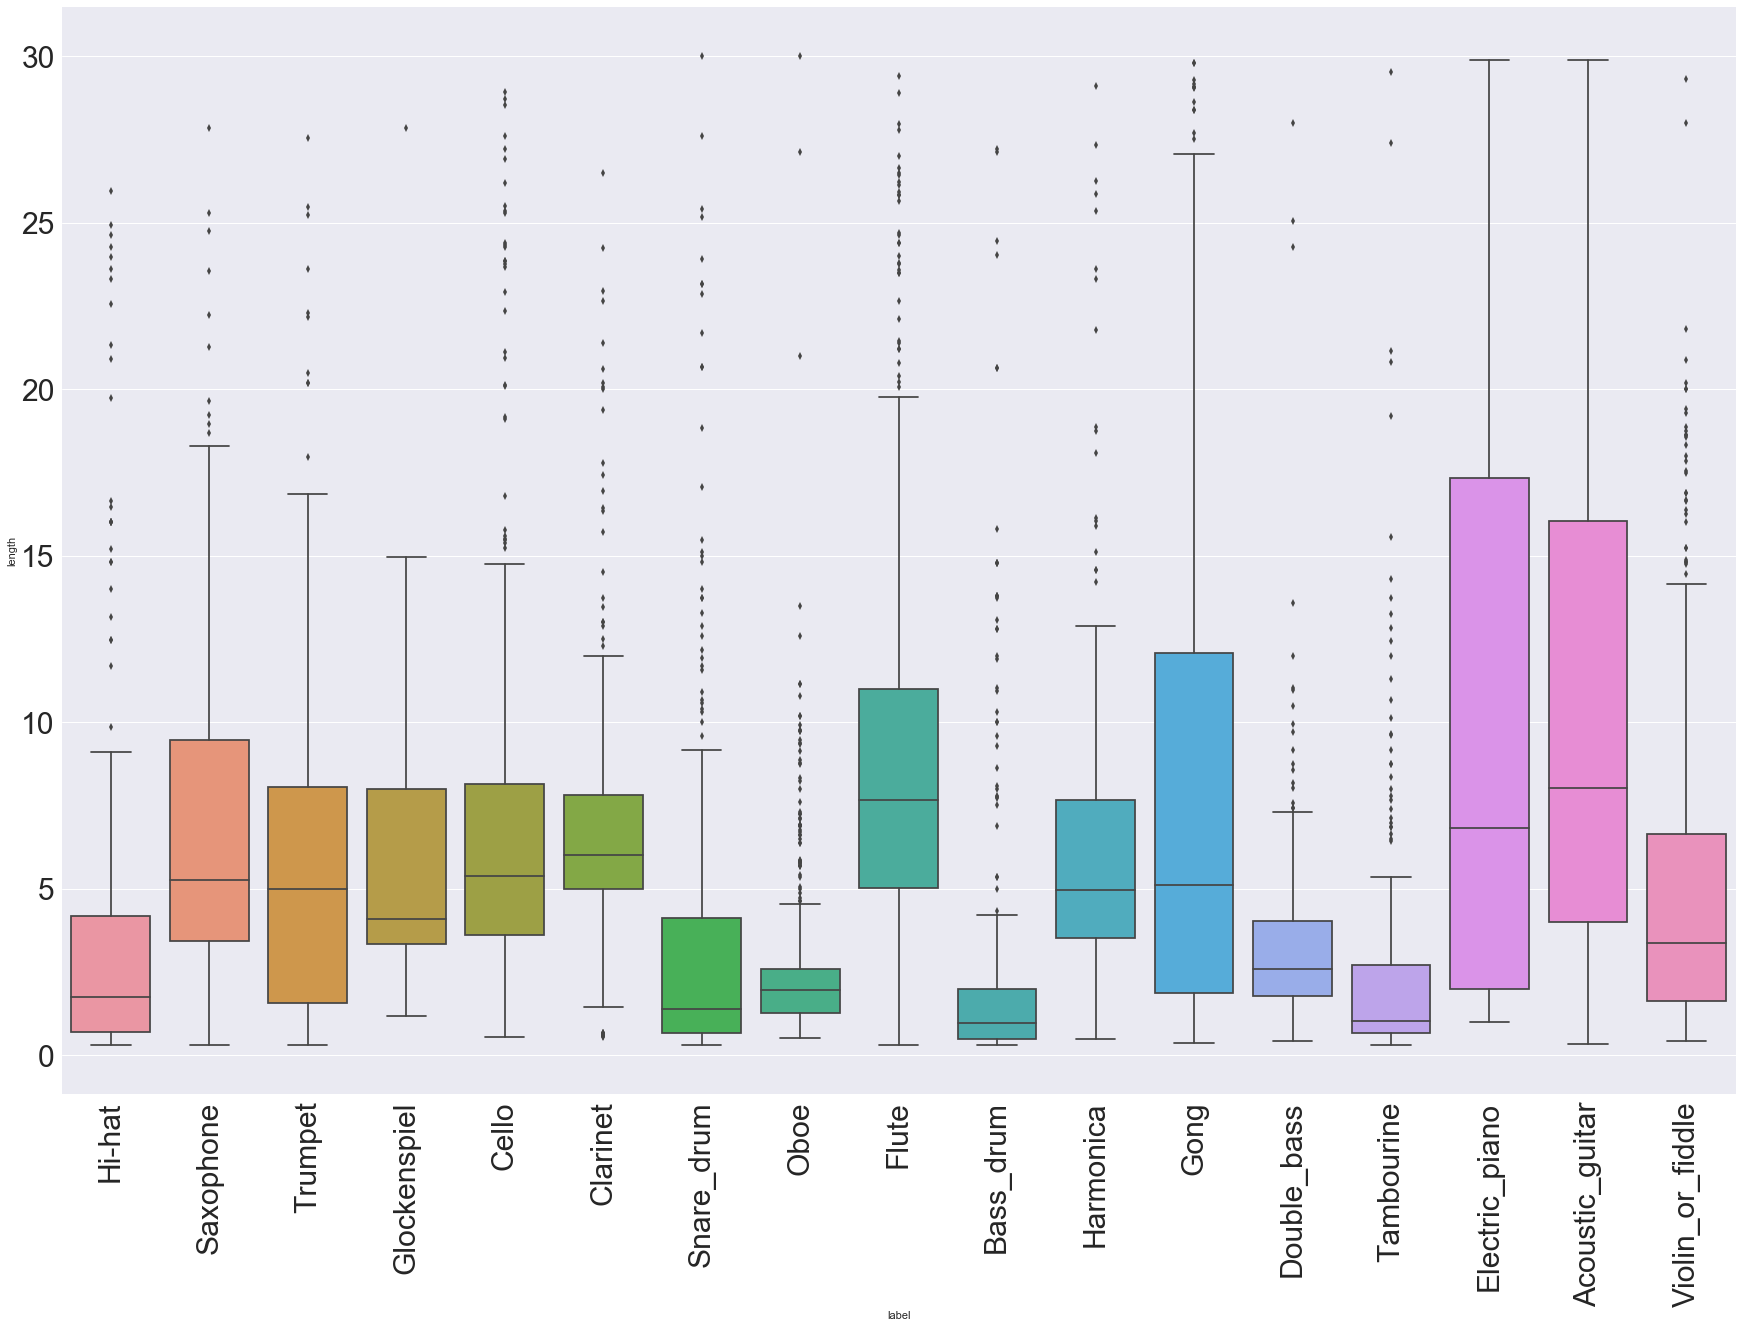

In [67]:
plt.figure(figsize=(30,20))
sns.boxplot(x='label',y='length',data=df_instruments)
plt.xticks(fontsize=30, rotation='vertical')
plt.yticks(fontsize=30)

# Cleaning audio files

In [4]:
def envelope(x, rate, threshold):
    mask = []
    x = pd.Series(x).apply(np.abs)
    y_mean = x.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [56]:
for f in tqdm(df_instruments.index):
    signal,rate = librosa.load('audio_train/'+f,sr=44100)
    mask=envelope(signal ,rate ,0.01)
    df_instruments.at[f, 'envelope']=signal[mask].shape[0]/44100

100%|██████████████████████████████████████████████████████████████████████████████| 4521/4521 [09:28<00:00, 10.83it/s]


In [57]:
for f in tqdm(df_env.index):
    signal,rate = librosa.load('audio_train/'+f,sr=44100)
    mask=envelope(signal ,rate ,0.01)
    df_env.at[f, 'envelope']=signal[mask].shape[0]/44100

100%|██████████████████████████████████████████████████████████████████████████████| 4952/4952 [12:57<00:00, 18.12it/s]


## Dropping empty files

In [58]:
list_null=list(df_instruments[df_instruments['envelope']== 0].index)

In [59]:
df_instruments=df_instruments.drop(list_null,axis=0)

In [60]:
list_null=list(df_env[df_env['envelope']== 0.0].index)

In [61]:
df_env.drop(list_null,axis=0,inplace=True)

In [5]:
#df_env.to_csv('env_sounds.csv')
df_env=pd.read_csv('env_sounds.csv')
df_env.set_index('fname',inplace=True)

In [6]:
#df_instruments.to_csv('instruments.csv')
df_instruments=pd.read_csv('instruments.csv')
df_instruments.set_index('fname',inplace=True)

# Data preprocessing

In [8]:
#df_instruments['counter']=0
#df_env['counter']=0

In [7]:
def data_processing(df,rate,length,path,csvfile):
    for f in tqdm(df.index):
        signal,rate = librosa.load('audio_train/'+f,sr=rate)
        mask = envelope(signal,rate,0.001)
        aux = signal[mask] #remove amplitudes less than 0.001
        if(aux.shape[0]/rate <= length):#audio file less than 4 seconds
            new=np.zeros(length*rate)
            shape=2*aux.shape[0]
            new[:aux.shape[0]]=aux
            while((shape/rate)<length):
                new[shape-aux.shape[0]:shape]=aux
                shape+=aux.shape[0]           
            shape-=aux.shape[0]
            diff=new[shape:].shape[0]
            new[shape:]=aux[:diff]
            wavfile.write(path+'/'+f, rate, new)
            df.at[f,'counter'] +=1
        else :
            shape=aux.shape[0]
            step=0
            for i in range(0,int(shape/(length*rate))-1):
                new = np.zeros(length*rate)
                new[:]=aux[step:step+length*rate]
                wavfile.write(path+'/'+str(df.at[f,'counter'])+'_'+f, rate, new)
                df.at[f,'counter'] +=1
                step+=length*rate
            if(shape%(length*rate)!=0):
                new=np.zeros(length*rate)
                new[:]=aux[shape-(length*rate):] #add the rest
                wavfile.write(path+'/'+str(df.at[f,'counter'])+'_'+f, rate, new)
                df.at[f,'counter'] +=1
    df.to_csv(csvfile)

In [ ]:
data_processing(df_instruments,rate=44100,length=4,path='Filtered_instruments',csvfile='instruments.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 4420/4420 [25:59<00:00,  5.36it/s]


In [10]:
data_processing(df_env,rate=44100,length=4,path='Filtered_env',csvfile='env_sounds.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 4730/4730 [31:16<00:00,  2.52it/s]


# Preparing MFCC features

In [8]:
from python_speech_features import mfcc
from keras.utils import to_categorical

Using TensorFlow backend.


In [9]:
class Config:
    def __init__(self, winlen=0.023 , winstep=0.01 ,nfeat=13,nfilt=26, nfft=1024, rate=44100):
        self.winlen=winlen
        self.winstep=winstep
        self.nfeat = nfeat
        self.nfilt=nfilt
        self.nfft = nfft
        self.rate = rate

In [14]:
def build_mfcc(config,df,directory):
    c = config
    X = []
    y = []
    error = 0 
    classes = list(np.unique(df.target))
    _min, _max = float('inf'), float('-inf')
    for f in tqdm(df.index):
        if(df.at[f,'counter']==1):
            try:
                signal,rate=librosa.load(directory+'/'+f,sr=44100)
            except:
                error += 1 
                continue
            label = df.at[f, 'target']
            X_mfcc = mfcc(signal, rate,
                                  winlen=c.winlen,winstep=c.winstep,numcep=c.nfeat, nfilt=c.nfilt, nfft=c.nfft,
                                  winfunc=lambda x: np.hamming(x)).T

            _min = min(np.amin(X_mfcc), _min)
            _max = max(np.amax(X_mfcc), _max)

            X.append(X_mfcc)
            y.append(classes.index(label))
        else:
            counter = df.at[f,'counter']
            for i in range(counter):
                try:
                    signal,rate=librosa.load(directory+'/'+str(i)+'_'+f,sr=44100)
                except:
                    df.at[f,'counter']-=1                    
                    continue
                label = df.at[f, 'target']
                X_mfcc = mfcc(signal, rate,
                                      winlen=c.winlen,winstep=c.winstep,numcep=c.nfeat, nfilt=c.nfilt, nfft=c.nfft,
                                      winfunc=lambda x: np.hamming(x)).T

                _min = min(np.amin(X_mfcc), _min)
                _max = max(np.amax(X_mfcc), _max)

                X.append(X_mfcc)
                y.append(classes.index(label))

    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    print(_min, _max)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes=len(classes))
    return X, y , error

In [15]:
config= Config( winlen=0.023 , winstep=0.01 ,nfeat=13,nfilt=26, nfft=1024, rate=44100)

In [16]:
X, y ,error= build_mfcc(config,df_instruments,'Filtered_instruments')

100%|██████████████████████████████████████████████████████████████████████████████| 4420/4420 [24:20<00:00,  3.03it/s]


-152.144687976 180.49846957


In [17]:
np.save('features/InstrumentsFeaturesLast',X,fix_imports=False)
np.save('features/InstrumentsLabelsLast',y,fix_imports=False)

In [19]:
X, y ,error= build_mfcc(config,df_env,'Filtered_env')

100%|██████████████████████████████████████████████████████████████████████████████| 4730/4730 [41:58<00:00,  3.60it/s]


-134.038533911 146.7676106


In [20]:
np.save('features/EnvFeaturesLast',X,fix_imports=False)
np.save('features/EnvLabelsLast',y,fix_imports=False)

In [ ]:
X=np.load('features/EnvFeaturesLast.npy')
y=np.load('features/EnvLabelsLast.npy')

#X=np.load('features/InstrumentsFeaturesLast.npy')
#y=np.load('features/InstrumentsLabelsLast.npy')

# Training the model

In [26]:
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense, Conv2D, MaxPool2D, Flatten,LeakyReLU
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools

### Instruments

In [27]:
def get_model_instruments(input_shape):
    K.clear_session()
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=(1, 1),
                     padding='same', input_shape=input_shape))
    model.add(LeakyReLU())
    
    model.add(Conv2D(32, (3, 3), strides=(1, 2),
                     padding='same')) 
    model.add(LeakyReLU())
    
    model.add(Conv2D(64, (3, 3), strides=(1, 2),
                     padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(128, (3, 3), strides=(1, 2),
                     padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, (3, 3), strides=(1, 2),
                     padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPool2D((2,2)))
    
        
    model.add(Conv2D(512, (3, 3),strides=(1, 2)))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1024, (3, 3), strides=(1, 1),
                     padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPool2D((2,2)))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(17, activation='softmax'))
    print("the input shape is"+str(input_shape))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['acc'])
    return model

In [28]:
y_flat = np.argmax(y, axis=1)

In [29]:
input_shape = (X.shape[1], X.shape[2], 1)

In [30]:
model = get_model_instruments(input_shape)

the input shape is(13, 399, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 399, 16)       160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 13, 399, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 200, 32)       4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 13, 200, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 100, 64)       18496     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 100, 64)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 50, 1

In [31]:
class_weight = compute_class_weight('balanced',
                                     np.unique(y_flat),
                                     y_flat)

In [ ]:
model.fit(X, y, epochs=25, batch_size=32,
          shuffle=True,
#          class_weight=class_weight)

In [ ]:
model_json = model.to_json()
with open("models/InstrumentsModel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/InstrumentsModel.h5")

### Env_sounds

In [32]:
def get_model_env(input_shape):
    K.clear_session()
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=(1, 1),
                     padding='same', input_shape=input_shape))
    model.add(LeakyReLU())
    
    model.add(Conv2D(32, (3, 3), strides=(1, 2),
                     padding='same')) 
    model.add(LeakyReLU())
    
    model.add(Conv2D(64, (3, 3), strides=(1, 2),
                     padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(128, (3, 3), strides=(1, 2),
                     padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, (3, 3), strides=(1, 2),
                     padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPool2D((2,2)))
    
        
    model.add(Conv2D(512, (3, 3),strides=(1, 2)))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1024, (3, 3), strides=(1, 1),
                     padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPool2D((2,2)))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(24, activation='softmax'))
    print("the input shape is"+str(input_shape))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['acc'])
    return model

In [33]:
y_flat = np.argmax(y, axis=1)

In [34]:
input_shape = (X.shape[1], X.shape[2], 1)

In [35]:
model = get_model_env(input_shape)

the input shape is(13, 399, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 399, 16)       160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 13, 399, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 200, 32)       4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 13, 200, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 100, 64)       18496     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 100, 64)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 50, 1

In [36]:
class_weight = compute_class_weight('balanced',
                                     np.unique(y_flat),
                                     y_flat)

In [ ]:
model.fit(X_env, y_env, epochs=30, batch_size=32,
          shuffle=True,
#          class_weight=class_weight)

In [ ]:
model_json = model.to_json()
with open("models/EnvModel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/EnvModel.h5")